In [1]:
import os
import time
import torch
import torchvision
import logging
import warnings
import datetime
import itertools
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from random import seed
import torch.optim as optim
from torch.utils import data
from torchvision import models
import pretrainedmodels as ptm
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
import torch.nn.functional as nnF
from imgaug import augmenters as iaa
from torch.utils.data import DataLoader
#from tensorboardX import SummaryWriter
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter

In [2]:
# On GPU or on CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

The model will run on cpu


C:\Users\user\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class MyDataset (data.Dataset):
    """
    This is the standard way to implement a dataset pipeline in PyTorch. We need to extend the torch.utils.data.Dataset
    class and implement the following methods: __len__, __getitem__ and the constructor __init__
    """

    def __init__(self, imgs_path, labels, meta_data=None, transform=None):
        """
        The constructor gets the images path and their respective labels and meta-data (if applicable).
        In addition, you can specify some transform operation to be carry out on the images.
        It's important to note the images must match with the labels (and meta-data if applicable). For example, the
        imgs_path[x]'s label must take place on labels[x].
        Parameters:
        :param imgs_path (list): a list of string containing the image paths
        :param labels (list) a list of labels for each image
        :param meta_data (list): a list of meta-data regarding each image. If None, there is no information.
        Defaul is None.
        :param transform (torchvision.transforms.Compose): transform operations to be carry out on the images



        The self parameter is a reference to the current instance of the class, and is used to access variables that belongs to the class.

        It does not have to be named self , you can call it whatever you like, but it has to be the first parameter of any function in the class:
        """

        super().__init__()
        self.imgs_path = imgs_path
        self.labels = labels
        self.meta_data = meta_data

        # if transform is None, we need to ensure that the PIL image will be transformed to tensor, otherwise we'll get
        # an exception
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):
        """ This method just returns the dataset size """
        return len(self.imgs_path)


    def __getitem__(self, item):
        """
        It gets the image, labels and meta-data (if applicable) according to the index informed in `item`.
        It also performs the transform on the image.
        :param item (int): an index in the interval [0, ..., len(img_paths)-1]
        :return (tuple): a tuple containing the image, its label and meta-data (if applicable)
        """

        image = Image.open(self.imgs_path[item]).convert("RGB")

        # Applying the transformations
        image = self.transform(image)

        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.meta_data is None:
            meta_data = []
        else:
            meta_data = self.meta_data[item]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, meta_data, img_id

In [4]:
def get_data_loader (imgs_path, labels, meta_data=None, transform=None, batch_size=32, shuf=False, num_workers=0,
                     pin_memory=True):
    """
    This function gets a list of images path, their labels and meta-data (if applicable) and returns a DataLoader
    for these files. You also can set some transformations using torchvision.transforms in order to perform data
    augmentation. Lastly, params is a dictionary that you can set the following parameters:
    batch_size (int): the batch size for the dataset. If it's not informed the default is 32
    shuf (bool): set it true if wanna shuffe the dataset. If it's not informed the default is True
    :param imgs_path (list): a list of string containing the images path
    :param labels (list): a list of labels for each image
    :param meta_data (list, optional): a list of meta-data regarding each image. If it's None, it means there's
    no meta-data. Default is None
    :param transform (torchvision.transforms, optional): use the torchvision.transforms.compose to perform the data
    augmentation for the dataset. Alternatively, you can use the jedy.pytorch.utils.augmentation to perform the
    augmentation. If it's None, none augmentation will be perform. Default is None
    :param num_workers (int): the number of threads to be used in CPU. If the key is not informed or params = None, the
    default value will be  4
    :param pin_memory (bool): set it to True to Pytorch preload the images on GPU. If the key is not informed or
    params = None, the default value will be True
    :return (torch.utils.data.DataLoader): a dataloader with the dataset and the chose params
    """

    dt = MyDataset(imgs_path, labels, meta_data, transform)
    dl = DataLoader (dataset=dt, batch_size=batch_size, shuffle=shuf, num_workers=num_workers,
                          pin_memory=pin_memory)
    return dl

In [33]:
def parse_metadata(data_csv, replace_nan=None, cols_to_parse=None, replace_rules=None, save_path=None):
    """
    This function parses the metadata within a csv/dataframe in order to transform string data in one_hot_encode
    information. For example, if you have a column Gender that assume values as 'Female' or 'Male', this code will
    create a new dataframe that replaces the column Gender to two columns: 'Female' and 'Male', in which will assume 1
    or 0, depending on the gender.

    :param data_csv (string or pandas.dataframe): the path for a csv or a dataframe already loaded
    :param replace_nan (string or int or float or boolean or None): if you have NaN or missing data in your dataset you
    can use this variable to replace them to a value. However, if you set it as None, the missing/NaN data will be
    removed from the dataset. Default is None.
    :param cols_to_parse (list, optional): a list of strings containing the column names to be parsed. If it's None,
    none column will be parsed to hot encode. Default is None.
    :param replace_rules (dict, optional): If you'd like to replace data in any column of your dataset, you can define
    this rules here. For example, supose I have a column call 'A' that assume values as 1 or 'b'. If you'd like to
    replace every incidence of 'b' to 2, you must do: replace_rules = {'A': {'b':2}}. Obviously, if you wanna insert
    more rules for the same column or for a different one, you just need to follow the pattern. If None, none rule will
    be carried out. Default is None.
    :param save_path (string, optional): if you want to save the final dataframe, just set the path. If None, the
    dataframe won't be save. Default is None.
    :return: a parsed pandas.dataframe
    """

    print("=" * 30)
    print(" Parsing the input csv ***")

    # Reading the csv
    if isinstance(data_csv, str):
        data = pd.read_csv(data_csv)
    else:
        data = data_csv

    # Checking if we need to remove any possible NaN
    if replace_nan is None:
        data = data.dropna()
    else:
        data = data.fillna(replace_nan)


    # If replace rules is true, we'll just replace the values by the given
    # rules dictionary
    if replace_rules is not None:
        cols_rules_keys = list(replace_rules.keys())
        for col in cols_rules_keys:
            col_rules = list(replace_rules[col].keys())
            col_values = list(replace_rules[col].values())
            try:
                data[col] = data[col].replace(col_rules, col_values)
            except TypeError:
                pass

    # If cols_to_handle is None the function will return the data without do anything
    new_col_names = list()
    if cols_to_parse is not None:

        for col in cols_to_parse:
            # Getting the unique values
            col_values = list(data[col].unique())

            # Removing all elements containing the replace_nan
            if replace_nan is not None:
                try:
                    col_values.remove(replace_nan)
                except ValueError:
                    pass

            # Sorting the values and saving them in new_col_names
            col_values.sort()
            new_col_names += col_values

        # Now, let's train to compose the new dataframe:
        # Getting the original col values and removing the handle ones
        original_col_names = list(data.columns.values)
        for c in cols_to_parse:
            original_col_names.remove(c)
            # Putting together the original and new columns. Now we have our final dataframe names
        data_col_names = original_col_names + new_col_names
        original_col_names = list(data.columns.values)

        # Now, let's iterate through the old data and get all values for each sample, replacing
        # for the one_hot encode if applicable
        values = list()
        for idx, row in data.iterrows():

            row_dict = {c: 0 for c in data_col_names}
            for col in original_col_names:
                if col in data_col_names:
                    row_dict[col] = row[col]
                else:
                    if replace_nan is not None:
                        if row[col] == replace_nan:
                            row_dict[row[col]] = 0
                        else:
                            row_dict[row[col]] = 1
                    else:
                        row_dict[row[col]] = 1

            values.append(row_dict)

        data = pd.DataFrame(values, columns=data_col_names)

    if save_path is not None:
        data.to_csv(save_path, columns=data_col_names, index=False)

    print("- csv parsed!")
    print("=" * 30)
    return data

In [34]:
def label_categorical_to_number (data_csv, col_target, col_target_number=None, save_path=None):
    """
    This function converts a label from categorical to number. The values are converted to code in alphabetic ordem.
    Example: for a set of labels ['A', 'B', 'C'] it converts to [0, 1, 2].
    :param data_csv (string or pd.DataFrame): the path for a csv or a dataframe already loaded
    :param col_target (string): the name of the target/label column
    :param col_target_number (string): if you want to control the name of the column with the convert number, just set
    the name here, otherwise it will set <col_target>_number
    :param save_path (string): the path to save the result of this function. Default is None
    return: it returns the same dataframe with an additional column called <col_target>_number or col_target_number
    """

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    data_csv[col_target] = data_csv[col_target].astype('category')
    if col_target_number is None:
        data_csv[col_target + '_number'] = data_csv[col_target].cat.codes
    else:
        data_csv[col_target_number] = data_csv[col_target].cat.codes

    if save_path is not None:
        data_csv.to_csv(save_path, index=False)

    return data_csv

In [35]:
def get_labels_frequency (data_csv, col_target, col_single_id, verbose=False):
    """
    This function returns the frequency of each label in the dataset
    :param data_csv (string or pd.DataFrame): the path for a csv or a dataframe already loaded
    :param col_target (string): the name of the target/label column
    :param col_single_id (string): the name any column that is present for all rows in the dataframe
    :param verbose (boolean): a boolean to print or not the frequencies
    return (pd.DataFrame): a dataframe containing the frequency of each label
    """

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    data_ = data_csv.groupby([col_target])[col_single_id].count()
    if (verbose):
        print('### Data summary: ###')
        print(data_)
        print(">> Total samples: {} <<".format(data_.sum()))

    return data_

In [67]:
class ImgTrainTransform:

    def __init__(self, size=(224,224), normalization=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):

        self.normalization = normalization
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.25, iaa.Affine(scale={"x": (1.0, 2.0), "y": (1.0, 2.0)})),
            iaa.Scale(size),
            iaa.Fliplr(1.0),
            iaa.Flipud(1.0),  # vertically flip 20% of all images
            iaa.Sometimes(1.0, iaa.Affine(rotate=(-90, 90), mode='symmetric')),
            iaa.Sometimes(1.0, iaa.Affine(rotate=(-180, 180), mode='symmetric')),
            iaa.Sometimes(1.0, iaa.Affine(rotate=(-270, 270), mode='symmetric')),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 1.5))),

            # noise
            iaa.Sometimes(0.1,
                          iaa.OneOf([
                              iaa.Dropout(p=(0, 0.05)),
                              iaa.CoarseDropout(0.02, size_percent=0.25)
                          ])),

            iaa.Sometimes(0.25,
                          iaa.OneOf([
                              iaa.Add((-15, 15), per_channel=0.5), # brightness
                              iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
                          ])),

        ])

    def __call__(self, img):
        img = self.aug.augment_image(np.array(img)).copy()
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(self.normalization[0], self.normalization[1]),
        ])
        return transforms(img)


class ImgEvalTransform:

    def __init__(self, size=(224,224), normalization=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):

        self.normalization = normalization
        self.size = size

    def __call__(self, img):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(self.normalization[0], self.normalization[1]),
        ])
        return transforms(img)

In [68]:
def one_hot_encoding(ind, N=None):
    """
    This function binarizes a vector (one hot enconding).
    For example:
    Input: v = [1,2,3]
    Output: v = [[1,0,0;
                0,1,0;
                0,0,1]]

    :param ind (numpy array): an numpy array 1 x n in which each position is a label
    :param N (int, optional): the number of indices. If None, the code get is from the shape. Default is None.

    :return (numpy.array): the one hot enconding array n x N
    """

    ind = np.asarray(ind)
    if ind is None:
        return None

    if N is None:
        N = ind.max() + 1

    return (np.arange(N) == ind[:, None]).astype(int)

In [69]:
def _check_dim (lab_real, lab_pred, mode='labels'):
    """
    This  function checks if y_real and y_pred are 1-d or 2-d. If mode is 'labels', this function returns an 1-d array
    ints, for ex: [0, 0, 1, 1, 2], in which each number is a label. If mode is 'scores', this function returns an 2-d
    array following the one hot encoding methos. For ex: [[0,0,0], [0,0,0], [0,1,0], [0,1,0], [0,0,1]]

    :param lab_real(1d or 2d n.array): the data real labels
    :param lab_pred(1d or 2d n.array): the predictions returned by the model
    :param mode (string, optional): the operation mode described above. Default is 'labels'
    :return (np.array, np.array): returns the lab_real and lab_pred transformed
    """
    if mode == 'labels':
        if lab_real.ndim == 2:
            lab_real = lab_real.argmax(axis=1)
        if lab_pred.ndim == 2:
            lab_pred = lab_pred.argmax(axis=1)

    elif mode == 'scores':
        if lab_real.ndim == 1:
            lab_real = one_hot_encoding(lab_real)
        if lab_pred.ndim == 1:
            lab_pred = one_hot_encoding(lab_pred)

    else:
        raise Exception ('There is no mode called {}. Please, choose between score or labels'.format(mode))

    return lab_real, lab_pred

In [70]:
class AVGMetrics (object):
    """
        This is a simple class to control the AVG for a given value. It's used to control loss and accuracy for start
        and evaluate partition
    """
    def __init__(self):
        self.sum_value = 0
        self.avg = 0
        self.count = 0
        self.values = []

    def __call__(self):
        return self.avg

    def update(self, val):
        self.values.append(val)
        self.sum_value += val
        self.count += 1
        self.avg = self.sum_value / float(self.count)

    def print (self):
        print('\nsum_value: ', self.sum_value)
        print('count: ', self.count)
        print('avg: ', self.avg)

In [71]:
def accuracy (lab_real, lab_pred, verbose=False):
    """
    Computess the accuracy. Both lab_real and lab_pred can be a labels array or and a array of
    scores (one hot encoding) for each class.

    :param lab_real(np.array): the data real labels
    :param lab_pred(np.array): the predictions returned by the model
    :param verbose(bool, optional): if you'd like to print the accuracy. Dafault is False.
    :return (float): the accuracy
    """

    # Checkin the array dimension
    lab_real, lab_pred = _check_dim (lab_real, lab_pred, mode='labels')

    acc = skmet.accuracy_score(lab_real, lab_pred)

    if verbose:
        print('- Accuracy - {:.3f}'.format(acc))

    return acc

In [72]:
class TrainHistory:
    
    def __init__(self):
        self.val_loss = list()
        self.val_acc = list()
        self.train_loss = list()
        self.train_acc = list()
        
    
    def update (self, loss_train, loss_val, acc_train, acc_val):
        """
        This function appends a new value to the loss/train loss and acc. These values are stored by epoch
        :param loss_train: the train loss of the ith epoch
        :param loss_val: the val loss of the ith epoch
        :param acc_train: the train accuracy of the ith epoch
        :param acc_val: the val accuracy of the ith epoch
        """

        self.train_loss.append(loss_train)
        self.val_loss.append(loss_val)
        self.train_acc.append(acc_train)
        self.val_acc.append(acc_val)


    def save (self, folder_path):
        """
        This function saves the loss and accuracy history as csv files
        :param folder_path: a string with the base folder path
        """

        path = os.path.join(folder_path, 'history')
        if not os.path.isdir(path):
            os.mkdir(path)

        print ("Saving history CSVs in {}".format(path))

        np.savetxt(os.path.join(path, "train_loss.csv"), np.asarray(self.train_loss), fmt='%.3f', delimiter=',')
        np.savetxt(os.path.join(path, "val_loss.csv"), np.asarray(self.val_loss), fmt='%.3f', delimiter=',')

        np.savetxt(os.path.join(path, "train_acc.csv"), np.asarray(self.train_acc), fmt='%.3f', delimiter=',')
        np.savetxt(os.path.join(path, "val_acc.csv"), np.asarray(self.val_acc), fmt='%.3f', delimiter=',')



    def save_plot (self, folder_path):
        """
        This function saves a plot of the loss and accuracy history
        :param folder_path: a string with the base folder path
        """

        path = os.path.join(folder_path, 'history')
        if not os.path.isdir(path):
            os.mkdir(path)

        epochs = [i + 1 for i in range(len(self.train_loss))]

        print("Saving history plots in {}".format(path))

        plt.plot(epochs, self.train_loss, color='r', linestyle='solid')
        plt.plot(epochs, self.val_loss, color='b', linestyle='solid')
        plt.grid(color='black', linestyle='dotted', linewidth=0.7)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.tight_layout()
        plt.savefig(os.path.join(path, "loss_history.jpg"), dpi=300)

        plt.figure()

        plt.plot(epochs, self.train_acc, color='r', linestyle='solid')
        plt.plot(epochs, self.val_acc, color='b', linestyle='solid')
        plt.grid(color='black', linestyle='dotted', linewidth=0.7)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.tight_layout()
        plt.savefig(os.path.join(path, "acc_history.jpg"), dpi=200)

        plt.figure()

In [73]:
def conf_matrix (lab_real, lab_pred, normalize=True):
    """
    This function computes the confusion matrix. Both lab_real and lab_pred can be a labels array or and a array of
    scores (one hot encoding) for each class.

    :param lab_real(np.array): the data real labels
    :param lab_pred(np.array): the predictions returned by the model
    :param class_names (list): the name of each label. For example: ['l1','l2']. If you pass a list with a different
    number of labels that provided in lad_pred or real, you're gonna have an exception. If None, the labels will not
    be considered. Default is None.
    :param normalize (bool, optional): set it True if you'd like to normalize the cm. Default is False.
    :return (2d np array: an np array containing the confusion matrix
    """

    # Checkin the array dimension
    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='labels')

    cm = skmet.confusion_matrix(lab_real, lab_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return cm

In [74]:
def plot_conf_matrix(cm, class_names, normalize=True, save_path=None, title='Confusion matrix', cmap=plt.cm.GnBu):
    """
    This function makes a plot for a given confusion matrix. It can plots either the real or normalized one.
    Most of this code is provided on:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

    Please, refers there for any further reference.

    :param cm (np.array): An m x m np array containing the confusion matrix
    :param class_names (list): a list with the class labels. Ex:['A', 'B'], if you have 2 labels
    :param normalize (bool, optional): set it True if you'd like to normalize the cm. Default is True.
    :param save_path (string, optional): if you'd like to save your plot instead of show it on the screen, you need to
    provide the full path (including image name and format) to do so. Ex: /home/user/cm.png. If None, the plot is not
    save but showed in the screen. Default is None.
    :param title (string, optional): the plot's title. Default is 'Confusion matrix'
    :param cmap (plt.cm.color, option): a color pallete provided by pyplot. Default is GnBu.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    if isinstance(save_path, str):
        plt.savefig(save_path, dpi=200)
        plt.clf()
    elif save_path:
        plt.show()
    else:
        plt.clf()

In [75]:
def precision_recall_report (lab_real, lab_pred, class_names=None, verbose=False, output_dict=False):
    """
    Computes the precision, recall, F1 score and support for each class. Both lab_real and lab_pred can be a labels
    array or and a array of scores (one hot encoding) for each class.

    :param lab_real (np.array): the data real labels
    :param lab_pred (np.array): the predictions returned by the model
    :param class_names (list): the name of each label. For example: ['l1','l2']. If you pass a list with a different
    number of labels that provided in lad_pred or real, you're gonna have an exception. If None, the labels will not
    be considered. Default is None.
    :return (string): a string containing the repost regarding each metric
    """

    # Checking the array dimension
    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='labels')

    report = skmet.classification_report(lab_real, lab_pred, target_names=class_names, output_dict=output_dict)

    if verbose:
         print(report)

    return report

In [76]:
def get_metrics_from_csv (csv, class_names=None, conf_mat=False, conf_mat_path=None, verbose=True):

    if isinstance(csv, str):
        data = pd.read_csv(csv)
    else:
        data = csv

    if class_names is None:
        class_names = data.columns.values[1:]

    class_names_dict = {name: pos for pos, name in enumerate(class_names)}
    preds = data[class_names].values

    try:
        labels_str = data['REAL'].values
    except KeyError:
        print ("Warning: There is no ground truth in this file! The code will return None")
        return None

    labels = [class_names_dict[lstr] for lstr in labels_str]
    labels = np.array(labels)

    acc = accuracy(labels, preds)
    rep =  precision_recall_report(labels, preds, class_names, output_dict=True)
    loss = skmet.log_loss(labels, preds)

    if conf_mat:
        plt.figure()
        cm = conf_matrix(labels, preds, normalize=True)
        if conf_mat_path is None:
            p = "./conf.jpg"
        else:
            p = conf_mat_path
        plot_conf_matrix(cm, class_names, title='Confusion matrix', cmap=plt.cm.GnBu, save_path=p)

    if verbose:
        print("-" * 50)
        print("- Metrics:")
        print("- Loss: {:.3f}".format(loss))
        print("- Accuracy: {:.3f}".format(acc))
        print("- Classification Report: {:.3f}".format(rep))

    return acc, rep, loss, fpr, tpr

In [77]:
def save_model (model, folder_path, epoch, opt_fn, loss_fn, is_best, multi_gpu=False, verbose=False):
    """
    This function saves the parameters of a model. It saves the last and best model (if it's the best).

    :param model (nn.Model): the model you wanna save the parameters
    :param folder_path (string): the folder you wanna save the checkpoints
    :param name_last (string): the file's name of the last checkpoint. Considers using epoch in the name
    :param name_best (bool, optional): the file's name of the best checkpoint. If it's False, it means this checkpoint
    :param verbose (bool, optional): If you'd like to print information on the screen. Default is False.
    is not the best one. Default is false.
    """

    last_check_path = os.path.join(folder_path, 'last-checkpoint')
    best_check_path = os.path.join(folder_path, 'best-checkpoint')

    if not os.path.exists(last_check_path):
        if verbose:
            print ('last-checkpoint folder does not exist. I am creating it!')
        os.mkdir(last_check_path)
    else:
        if verbose:
            print ('last-checkpoint folder exist! Perfect, I will just use it.')

    if not os.path.exists(best_check_path):
        if verbose:
            print('best-checkpoint folder does not exist. I am creating it!')
        os.mkdir(best_check_path)
    else:
        if verbose:
            print('best-checkpoint folder exist! Perfect, I will just use it.')

    info_to_save = {
        'epoch': epoch,
        'model_state_dict': model.module.state_dict() if multi_gpu else model.state_dict(),
        'optimizer_state_dict': opt_fn.state_dict(),
        'loss': loss_fn,
    }

    torch.save(info_to_save, os.path.join(last_check_path, "last-checkpoint.pth"))

    if is_best:
        torch.save(info_to_save, os.path.join(best_check_path, 'best-checkpoint.pth'))

In [78]:
def load_model (checkpoint_path, model, opt_fn=None, loss_fn=None, epoch=None):
    """
    This function loads a model from a given checkpoint.

    :param checkpoint_path (string): the full path to de checkpoint
    :param model (nn.Model): the model that you wanna load the parameters
    :return (nn.Model): the loaded model
    """

    if not os.path.exists(checkpoint_path):
        raise Exception ("The {} does not exist!".format(checkpoint_path))

    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['model_state_dict'])

    if opt_fn is not None and loss_fn is not None:
        opt_fn.load_state_dict(ckpt['optimizer_state_dict'])
        epoch = ckpt['epoch']
        loss_fn = ckpt['loss']
        return model, opt_fn, loss_fn, epoch
    else:
        return model

In [79]:
def split_k_folder_csv (data_csv, col_target, save_path=None, k_folder=10, seed_number=None):
    """
    This function gets a csv/dataframe and creates a new column called 'folder' that represents the k-folder cross
    validation
    :param data_csv (string or pd.DataFrame): the path for a csv or a dataframe already loaded
    :param col_target (string): the name of the target/label column
    :param k_folder(int): the number of folders for the cross validation
    :param save_path (string): the path to save the result of this function. Default is None
    :param seed_number (number, optional): a seed number to guarantee reproducibility
    return (pd.DataFrame): the dataframe with the new column
    """

    print("=" * 30)
    print("- Generating the {}-foders***".format(k_folder))

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    skf = StratifiedKFold(k_folder, True, seed_number)
    target = data_csv[col_target]
    data_csv['folder'] = None
    for folder_number, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(target)), target)):
        data_csv.loc[val_idx, 'folder'] = folder_number + 1

    if save_path is not None:
        data_csv.to_csv(save_path, index=False)

    print(" Done!")
    print("=" * 30)

    return data_csv

In [80]:
BASE_PATH = "E:/Skin_App/Drive"


data = parse_metadata (os.path.join(BASE_PATH, "train_meta_data.csv"), replace_nan="missing",
           cols_to_parse=['Gender', 'Anatomical_Site'], replace_rules={"Approximated_Age": {"missing": 0}})


data = split_k_folder_csv(data, "Diagnosis", save_path=None, k_folder=10, seed_number=8)
data = label_categorical_to_number (data, "Diagnosis", col_target_number="Diagnosis_number")
data_test = data[ data['folder'] == 10]
data_train = data[ data['folder'] != 10]
data_train.to_csv(os.path.join(BASE_PATH, "ked_parsed_train.csv"), index=False)
data_test.to_csv(os.path.join(BASE_PATH, "ked_parsed_test.csv"), index=False)

 Parsing the input csv ***
- csv parsed!
- Generating the 10-foders***
 Done!


In [81]:
class Metrics:

    def __init__(self, metrics_names, class_names=None, options=None):
        """
        Construction method. You must inform the metrics you'd like to compute. Optionally, you may set some options 
        and the classes names. Each parameter is better described bellow:
        
        :param metrics_name (list, tuple or string): it's the variable that receives the metrics you'd like to compute.
        The following metrics are available: "accuracy", "conf_matrix", "plot_conf_matrix", "precision_recall_report". 
        
        To understand them, please, go to jedy.utils.classification_metrics.py.
        
        You should pass one or more of these metrics in a list or a tuple, 
        for ex: m = ["accuracy", "conf_matrix"]. If you'd like to compute all of them, just set it as 'all', i.e., 
        m = 'all'
        
        Important: if you'd like to compute either 'plot_conf_matrix' or 'auc_and_roc_curve', you must inform the
        class_names. If not, you'll get an exception. The remaining metrics, except 'accuracy', also use the class_name,
        however, it's not demanded for them
        
        :param class_names (list, tuple): a list or tuple containing the classes names in the same order you use in the
        label. For ex: ['C1', 'C2']

        :param options (dict): this is a dict containing some options to compute the metrics. The following options are
        available:
        - For all:
            - save_all_path: a string with the path to save all metrics and images. In this case, the conf matrix will be
            called by conf_mat.jpg


        - For 'conf_matrix': 
            - 'normalize_conf_matrix' (bool): inform if you'd like to normalize the confusion matrix
        
        - For 'plot_conf_matrix':
            - 'save_path_conf_matrix' (string): the complete file path if you'd like to save instead show the plot
            - 'normalize_conf_matrix' (bool): inform if you'd like to normalize the confusion matrix
            - 'title_conf_matrix' (string): the plot's title

        - For 'save_scores':
            - 'save_path_scores' (string): the complete file path if to save the scores
            - 'pred_name_scores' (string): the names of the predictions .csv. If it's not informed, it's going to be
            predictions.csv
            
        For more information about the options, please, refers to jedy.utils.classification_metrics.py
         
        """
        self.metrics_names = metrics_names
        self.metrics_values = dict()        
        self.options = options
        
        self.pred_scores = None
        self.label_scores = None
        self.img_names = None
        
        self.class_names = class_names


    def compute_metrics (self):
        """
        This method computes all metrics defined in metrics_name.
        :return: it saves in self.metric_values all computed metrics
        """

        save_all_path = None
        # Checking if save_all is informed
        if self.options is not None:
            if "save_all_path" in self.options.keys():
                # Checking if the folder doesn't exist. If True, we must create it.
                if not os.path.isdir(self.options["save_all_path"]):
                    os.mkdir(self.options["save_all_path"])
                save_all_path = self.options["save_all_path"]

        if self.metrics_names is None:
            return None
        
        if self.metrics_names == "all":
            self.metrics_names = ["accuracy", "conf_matrix", "plot_conf_matrix", "precision_recall_report"]
        
        
        for mets in self.metrics_names:
            if mets == "accuracy":
                self.metrics_values["accuracy"] = accuracy(self.label_scores, self.pred_scores)

            
            elif mets == "conf_matrix":
                
                # Checking the options
                normalize = True
                if self.options is not None:
                    if "normalize_conf_matrix" in self.options.keys():
                        normalize = self.options["normalize_conf_matrix"]
                
                self.metrics_values["conf_matrix"] = conf_matrix(self.label_scores, self.pred_scores, normalize)
            elif mets == "plot_conf_matrix":
                
                # Checking if the class names are defined
                if self.class_names is None:
                    raise Exception ("You are trying to plot the confusion matrix without defining the classes name")
                
                # Checking the options
                save_path = None
                normalize = True
                title = "Confusion Matrix"   
                
                if self.options is not None:
                    if save_all_path is not None:
                        save_path = os.path.join(save_all_path, "confusion_matrix.jpg")
                    if "save_path_conf_matrix" in self.options.keys():
                        save_path = self.options["save_path_conf_matrix"]
                    if "normalize_conf_matrix" in self.options.keys():
                        normalize = self.options["normalize_conf_matrix"]
                    if "title_conf_matrix" in self.options.keys():
                        title = self.options["title_conf_matrix"]
                        
                if "conf_matrix" in self.metrics_values.keys():
                    cm = self.metrics_values["conf_matrix"]
                else:
                    cm = conf_matrix(self.label_scores, self.pred_scores, normalize)
                
                plot_conf_matrix(cm, self.class_names, normalize, save_path, title)
                
                
            elif mets == "precision_recall_report":
                
                self.metrics_values["precision_recall_report"] = precision_recall_report(self.label_scores,
                                                                                              self.pred_scores,
                                                                                              self.class_names)

            
    def print (self):
        """
        This method just prints the metrics on the screen
        """
        
        if self.metrics_names is None:
            print ("Since metrics name is None, there is no metric to print")
            
        else:        
            for met in self.metrics_values.keys():
                if met == "loss":
                    print ('- Loss: {:.3f}'.format(self.metrics_values[met]))
                elif met == "accuracy":
                    print ('- Accuracy: {:.3f}'.format(self.metrics_values[met]))
                elif met == "conf_matrix":
                    print('- Confusion Matrix: \n{}'.format(self.metrics_values[met]))
                elif met == "precision_recall_report":
                    print('- Precision and Recall report: \n{}'.format(self.metrics_values[met]))

    def add_metric_value (self, value_name, value):
        """
        Adding a new value from a external source into the metrics
        :param value_name (string): the key for the dict
        :param value: the value to be saved in the self.metrics_values
        """
        self.metrics_values[value_name] = value


    def update_scores (self, label_batch, pred_batch, img_name_batch=None):
        """
        The evaluation is made using batchs. So, every batch we get just a piece of the prediction. This method
        concatenate all prediction and labels in order to compute the metrics
        :param pred (np.array): an array containing part of the predictions outputed by the model
        :param label (np.array): an array contaning the true labels
        """

        if self.label_scores is None and self.pred_scores is None:
            self.label_scores = label_batch
            self.pred_scores = pred_batch
            self.img_names = img_name_batch
        else:
            if pred_batch is not None:
                self.pred_scores = np.concatenate((self.pred_scores, pred_batch))
            if label_batch is not None:
                self.label_scores = np.concatenate((self.label_scores, label_batch))
            if img_name_batch is not None:
                self.img_names = np.concatenate((self.img_names, img_name_batch))


    def save_metrics (self, folder_path, name="metrics.txt"):
        """
        This method saves the computed metrics
        :param folder_path (string): the folder you'd like to save the metrics
        :param name (string): the file name. Default is metrics.txt
        """
        
        if self.metrics_names is None:
            print ("Since metrics name is None, there is no metric to save")
            
        else:        
            with open(os.path.join(folder_path, name), "w") as f:
    
                f.write("- METRICS REPORT -\n\n")
    
                for met in self.metrics_values.keys():
                    if met == "loss":
                        f.write('- Loss: {:.3f}\n'.format(self.metrics_values[met]))
                    elif met == "accuracy":
                        f.write('- Accuracy: {:.3f}\n'.format(self.metrics_values[met]))
                    elif met == "conf_matrix":
                        f.write('- Confusion Matrix: \n{}\n'.format(self.metrics_values[met]))
                    elif met == "precision_recall_report":
                        f.write('- Precision and Recall report: \n{}\n'.format(self.metrics_values[met]))


    def save_scores (self, folder_path=None, pred_name="predictions.csv"):
        """
        This method saves the concatenated scores in the disk
        :param folder_path (string): the folder you'd like to save the scores
        :param pred_name (string): the predictions' score file name. Default is predictions.csv
        :param labels_name (string): the labels' score file name. Default is labels.csv
        """

        if folder_path is not None:
            # Checking if the folder doesn't exist. If True, we must create it.
            if not os.path.isdir(folder_path):
                os.mkdir(folder_path)
        elif self.options is not None:
            if "save_all_path" in self.options.keys():
                folder_path = self.options["save_all_path"]
            elif "save_path_scores" in self.options.keys():
                folder_path = self.options["save_path_scores"]
            else:
                raise ("The options doesnt have any folder to save the scores")

            if 'pred_name_scores' in self.options.keys():
                pred_name = self.options['pred_name_scores']
        else:
            raise ("You must set the path to save the score eithe in options or in folder_path parameter")


        # Getting the list of classications and predict labels
        if self.class_names is not None:
            if self.label_scores is not None:
                real_labels = [self.class_names[int(l)] for l in self.label_scores]
                real_labels = np.asarray(real_labels)
                real_labels = real_labels.reshape(real_labels.shape[0], 1)

            if self.img_names is not None:
                img_names = np.asarray(self.img_names)
                img_names = img_names.reshape(img_names.shape[0], 1)

            pred_labels = [self.class_names[ps.argmax()] for ps in self.pred_scores]
            pred_labels = np.asarray(pred_labels)
            pred_labels = pred_labels.reshape(pred_labels.shape[0], 1)
        else:
            raise ("You need to inform the class names to use this function")

        if self.img_names is not None and self.label_scores is not None:
            both_data = np.concatenate((img_names, real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['image', 'REAL', 'PRED', *self.class_names]
        elif self.img_names is None and self.label_scores is not None:
            both_data = np.concatenate((real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['REAL', 'PRED', *self.class_names]
        elif self.img_names is not None and self.label_scores is None:
            both_data = np.concatenate((img_names, pred_labels, self.pred_scores), axis=1)
            cols = ['image', 'PRED', *self.class_names]
        else:
            both_data = np.concatenate((real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['REAL', 'PRED', *self.class_names]

        df = pd.DataFrame(both_data, columns=cols)
        print ("Saving the scores in {}".format(folder_path))

        df.to_csv(os.path.join(folder_path, pred_name), index=False)

In [82]:
class MyMobilenet (nn.Module):

    def __init__(self, mobilenet, num_class, freeze_conv=False, p_dropout=0.5,
                 comb_method=None, comb_config=None, n_feat_conv=1280):

        super(MyMobilenet, self).__init__()

        _n_meta_data = 0
        if comb_method is not None:
            
            if comb_method == 'concat':
                if not isinstance(comb_config, int):
                    raise Exception("comb_config must be int for 'concat' method")
                _n_meta_data = comb_config
                self.comb = 'concat'
            else:
                raise Exception("There is no comb_method called " + comb_method + ". Please, check this out.")
        else:
            self.comb = None

        self.features = nn.Sequential(*list(mobilenet.children())[:-1])
        # freezing the convolution layers
        if freeze_conv:
            for param in self.features.parameters():
                param.requires_grad = False

        self.classifier = nn.Linear(n_feat_conv + _n_meta_data, num_class)

    def forward(self, img, meta_data=None):

        # Checking if when passing the metadata, the combination method is set
        if meta_data is not None and self.comb is None:
            raise Exception("There is no combination method defined but you passed the metadata to the model!")
        if meta_data is None and self.comb is not None:
            raise Exception("You must pass meta_data since you're using a combination method!")

        x = self.features(img)
        x = x.mean([2, 3])

        if self.comb == 'concat':
            x = x.view(x.size(0), -1) # flatting
            x = torch.cat([x, meta_data], dim=1) # concatenation
        return self.classifier(x)

In [83]:
_MODELS = ['mobilenet']


def set_model (model_name, num_class,comb_method=None, comb_config=None, 
               pretrained=True,freeze_conv=False):

    if pretrained:
        pre_torch = True
    else:
        pre_torch = False

    if model_name not in _MODELS:
        raise Exception("The model {} is not available!".format(model_name))

    model = None
    if model_name == 'mobilenet':
        model = MyMobilenet(models.mobilenet_v2(pretrained=pre_torch), num_class, freeze_conv,
                            comb_method=comb_method, comb_config=comb_config)
    return model

In [84]:
def _config_logger(save_path, file_name):
    """
        Internal function to configure the logger

    """
    
    logger = logging.getLogger("Train-Logger")
    # Checking if the folder logs doesn't exist. If True, we must create it.
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    logger_filename = os.path.join(save_path, f"{file_name}_{str(time.time()).replace('.','')}.log")
    fhandler = logging.FileHandler(filename=logger_filename, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(logging.INFO)
    return logger


def _train_epoch (model, optimizer, loss_fn, data_loader, c_epoch, t_epoch, device=None):
    """
    This function trains an epoch of the dataset, that is, it goes through all dataset batches once.
    :param model (torch.nn.Module): a module to be trained
    :param optimizer (torch.optim.optim): an optimizer to fit the model
    :param loss_fn (torch.nn.Loss): a loss function to evaluate the model prediction
    :param data_loader (torch.utils.DataLoader): a dataloader containing the dataset
    :param c_epoch (int): the current epoch
    :param t_epoch (int): the total number of epochs
    :param device (torch.device): the device to carry out the training 
    """
    
   
    # setting the model to training mode
    model.train()

    print ("Training...")
    # Setting tqdm to show some information on the screen
    with tqdm(total=len(data_loader), ascii=True, desc='Epoch {}/{}: '.format(c_epoch, t_epoch), ncols=100) as t:


        # Variables to store the avg metrics
        loss_avg = AVGMetrics()
        acc_avg = AVGMetrics()

        # Getting the data from the DataLoader generator
        for batch, data in enumerate(data_loader, 0):


            # In data we may have imgs, labels and extra info. If extra info is [], it means we don't have it
            # for the this training case. Imgs came in data[0], labels in data[1] and extra info in data[2]
            try:
                imgs_batch, labels_batch, metadata_batch, _ = data
            except ValueError:
                imgs_batch, labels_batch = data
                metadata_batch = []

            if len(metadata_batch):
                # In this case we have extra information and we need to pass this data to the model
                # Moving the data to the deviced that we set above
                imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)
                metadata_batch = metadata_batch.to(device)
                metadata_batch = metadata_batch.float()

                # Doing the forward pass
                out = model(imgs_batch, metadata_batch)
            else:
                # In this case we don't have extra info, so the model doesn't expect for it
                # Moving the data to the deviced that we set above
                imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)

                # Doing the forward pass
                out = model(imgs_batch)

            # Computing loss function
            loss = loss_fn(out, labels_batch)

            # Computing the accuracy
            acc = accuracy(out, labels_batch)

            # Getting the avg metrics
            loss_avg.update(loss.item())
            acc_avg.update(acc.item())

            # Zero the parameters gradient
            optimizer.zero_grad()

            # Computing gradients and performing the update step
            loss.backward()
            optimizer.step()

            # Updating tqdm
            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    return {"loss": loss_avg(), "accuracy": acc_avg()}

def fit_model (model, train_data_loader, val_data_loader, optimizer=None, loss_fn=None, epochs=1,
               epochs_early_stop=None, save_folder=None, initial_model=None, best_metric="loss", device=None,
               schedule_lr=None, config_bot=None, model_name="CNN", resume_train=False, history_plot=True,
               val_metrics=('accuracy'), metric_early_stop=None):
    """
    This is the main function to carry out the training phase.

    :param c_epoch (int): the current epoch
    :param t_epoch (int): the total number of epochs
    :param device (torch.device): the device to carry out the training
    :param model (torch.nn.Module): a module to be trained
    :param train_data_loader (torch.utils.DataLoader): a dataloader containing the start dataset
    :param val_data_loader (torch.utils.DataLoader): a dataloader containing the validation dataset
    :param optimizer (torch.optim.optim, optional): an optimizer to fit the model. If None, it will use the
     optim.Adam(model.parameters(), lr=0.001). Default is None.
    :param loss_fn (torch.nn.Loss, optional): a loss function to evaluate the model prediction. If None, it will use the
    nn.CrossEntropyLoss(). Default is None.
    :param epochs (int, optional): the number of epochs to start the model. Default is 10.
    :param epochs_early_stop (int, optional): if you'd like to check early stop, pass the number of epochs that need to
    be achieved to stop the training. It checks if the loss is improving. If it doesn't improve for epochs_early_stop,
    training stops. If None, the training is never stopped. Default is None.
    :param save_folder (string, optional): if you'd like to save the last and best checkpoints, just pass the folder
    path in which the checkpoint will be saved. If None, the model is not saved in the disk. Default is None.
    :param initial_model (string, optinal): if you'd like to restart the training from a given saved checkpoint, pass
    the path to this file here. If None, the model starts training from scratch. Default is None.
    :param resume_train (bool, optional): if you'd like to resume the training using the last values for optimizer and
    starting from the last epoch trained, set it True. Default is False.
    :param class_names (list, optional): the list of class names.
    :param best_metric (string, optional): if you chose save the model, you can inform the metric you'd like to save as
    the best. Default is loss.
    :param device (torch.device): the device you'd like to start the model. If None, it will check if you have a GPU
    available. If not, it use the CPU. Default is None.
    :param topk: number of top accuracies to compute
    :param schedule_lr (bool, optional): If you're using a schedule for the learning rate you need to pass it using this
    variable. If this is None, no schdule will be performed. Default is None.
    :param config_bot (string or dictionary, optional): this is a string containing the chat_id for the bot or a dict
    containing the chat_id and the token, example: {chat_id: xxx, token: yyy}. If None, the chat_bot will not be used.
    Default is None.
    :param model_name (string, optional): this is the model's name, ex: ResNet. Defaul is CNN.
    """

    logger = _config_logger(save_folder, model_name)
    logger.info("Starting the training phase")

    if epochs_early_stop is not None:
        logger.info('Early stopping is set using the number of epochs without improvement')
    if metric_early_stop is not None:
        logger.info('Early stopping is set using the min/max metric as threshold')
    if epochs_early_stop is None and metric_early_stop is None:
        logger.info('No early stopping is set')

    history = TrainHistory()

    # Checking if we have a saved model. If we have, load it, otherwise, let's start the model from scratch
    epoch_resume = 0
    if initial_model is not None:
        logger.info("Loading the saved model in {} folder".format(initial_model))

        if resume_train:
            model, optimizer, loss_fn, epoch_resume = load_model(initial_model, model)
            logger.info("Resuming the training from epoch {} ...".format(epoch_resume))
        else:
            model = load_model(initial_model, model)

    else:
        logger.info("The model will be trained from scratch")


    # Setting the device(s)
    # If GPU is available, let's move the model to there. If you have more than one, let's use them!
    """
    m_gpu = 0
    if device is None:
        if torch.cuda.is_available():

            device = torch.device("cuda")
            # device = torch.device("cuda:" + str(torch.cuda.current_device()))
            m_gpu = torch.cuda.device_count()
            if m_gpu > 1:
                logger.info("The training will be carry out using {} GPUs:".format(m_gpu))
                for g in range(m_gpu):
                    logger.info(torch.cuda.get_device_name(g))

                model = nn.DataParallel(model)
            else:
                logger.info("The training will be carry out using 1 GPU:")
                logger.info(torch.cuda.get_device_name(0))
        else:
            logger.info("The training will be carry out using CPU")
            device = torch.device("cpu")
    else:
        logger.info("The training will be carry out using 1 GPU:")
        logger.info(torch.cuda.get_device_name(device))
        
        """


    # Moving the model to the given device
    model.to(device)

    # Setting data to store the best mestric
    logging.info("The best metric to get the best model will be {}".format(best_metric))
    if best_metric == 'loss':
        best_metric_value = 1000
    else:
        best_metric_value = 0
    best_flag = False

    # Checking if we need to compute the balanced accuracy
    if val_metrics is None:
        get_bal_acc = False
    else:
        get_bal_acc = 'balanced_accuracy' in val_metrics

    # setting a flag for the early stop
    early_stop_count = 0
    best_epoch = 0

    # writer is used to generate the summary files to be loaded at tensorboard
    writer = SummaryWriter (os.path.join(save_folder, 'summaries'))

    
    # Let's iterate for `epoch` epochs or a tolerance.
    # It always start from epoch resume. If it's set, it starts from the last epoch the training phase was stopped,
    # otherwise, it starts from 0
    epoch = epoch_resume
    while epoch < epochs:

        # Updating epoch
        epoch += 1

        # Training and getting the metrics for one epoch
        train_metrics = _train_epoch(model, optimizer, loss_fn, train_data_loader, epochs, device)

        # After each epoch, we evaluate the model for the training and validation data
        val_metrics = metrics_for_eval (model, val_data_loader, device, loss_fn)

        # Checking the schedule if applicable
        if isinstance(schedule_lr, torch.optim.lr_scheduler.ReduceLROnPlateau):
            schedule_lr.step(best_metric_value)
        elif isinstance(schedule_lr, torch.optim.lr_scheduler.MultiStepLR):
            schedule_lr.step(epoch)

        # Getting the current LR
        current_LR = None
        for param_group in optimizer.param_groups:
            current_LR = param_group['lr']


        writer.add_scalars('Loss', {'val-loss': val_metrics['loss'],
                                                 'start-loss': train_metrics['loss']},
                                                 epoch)

        writer.add_scalars('Accuracy', {'val-loss': val_metrics['accuracy'],
                                    'start-loss': train_metrics['accuracy']},
                                    epoch)

        history.update(train_metrics['loss'], val_metrics['loss'], train_metrics['accuracy'], val_metrics['accuracy'])


        # Getting the metrics for the training partition epoch
        train_print = "-- Loss: {:.3f}\n-- Acc: {:.3f}\n".format(train_metrics["loss"],train_metrics["accuracy"])

        # Getting the metrics for the validation partition in this epoch
        val_print = "-- Loss: {:.3f}\n-- Acc: {:.3f}\n".format(val_metrics["loss"],val_metrics["accuracy"])

        early_stop_count += 1
        new_best_print = None
        # Defining the best metric for validation
        if best_metric == 'loss':
            if val_metrics[best_metric] <= best_metric_value:
                best_metric_value = val_metrics[best_metric]
                new_best_print = '\n-- New best {}: {:.3f}'.format(best_metric, best_metric_value)
                best_flag = True
                best_epoch = epoch
                early_stop_count = 0
        else:
            if val_metrics[best_metric] >= best_metric_value:
                best_metric_value = val_metrics[best_metric]
                new_best_print = '\-- New best {}: {:.3f}'.format(best_metric, best_metric_value)
                best_flag = True
                best_epoch = epoch
                early_stop_count = 0

        # Check if it's the best model in order to save it
        if save_folder is not None:
            save_model(model, save_folder, epoch, optimizer, loss_fn, best_flag)
        best_flag = False

        # Updating the logger
        msg = "Metrics for epoch {} out of {}\n".format(epoch, epochs)
        msg += "- Train\n"
        msg += train_print + "\n"
        msg += "\n- Validation\n"
        msg += val_print + "\n"
        msg += "\n- Training info"
        msg += "\n-- Early stopping counting: {} max to stop is {}".format(early_stop_count, epochs_early_stop)
        msg += "\n-- Current LR: {}".format(current_LR)
        if new_best_print is not None:
            msg += new_best_print
        msg += "\n-- Best {} so far: {:.3f} on epoch {}\n".format(best_metric, best_metric_value, best_epoch)

        # Checking the early stop
        if epochs_early_stop is not None:
            if early_stop_count >= epochs_early_stop:
                logger.info(msg)
                logger.info("The early stop trigger was activated. The validation {} " .format(best_metric) +
                            "{:.3f} did not improved for {} epochs.".format(best_metric_value,
                                                                            epochs_early_stop) +
                            "The training phase was stopped.")

                break

        # Checking the early stop
        if metric_early_stop is not None:
            stop = False
            if best_metric == 'loss':
                if metric_early_stop >= best_metric_value:
                    stop = True
            else:
                if metric_early_stop <= best_metric_value:
                    stop = True

            if stop:
                logger.info(msg)
                logger.info("The early stop trigger was activated. The validation {} ".format(best_metric) +
                            "{:.3f} achieved the defined threshold {:.3f}.".format(best_metric_value,
                                                                            metric_early_stop) +
                            "The training phase was stopped.")
                break

        # Sending all message to the logger
        logger.info(msg)


    if history_plot:
        history.save_plot(save_folder)

    history.save(save_folder)
    print('\n')

    writer.close()

In [85]:
def metrics_for_eval (model, data_loader, device, loss_fn):
    """
        This function returns accuracy and loss for the evaluation partition

        :param model (nn.Model): the model you' want to evaluate
        :param data_loader (DataLoader): the DataLoader containing the data partition
        :param checkpoint_path(string, optional): string with a checkpoint to load the model. If None, none checkpoint is
        loaded. Default is None.
        :param loss_fn (nn.Loss): the loss function used in the training
        :return: a instance of the classe metrics
    """

    # setting the model to evaluation mode
    model.eval()

    print ("\nEvaluating...")
    # Setting tqdm to show some information on the screen
    
    with tqdm(total=len(data_loader), ascii=True, ncols=100) as t:

        # Setting require_grad=False in order to dimiss the gradient computation in the graph
        with torch.no_grad():

            loss_avg = AVGMetrics()
            acc_avg = AVGMetrics()


            for data in data_loader:

                # In data we may have imgs, labels and extra info. If extra info is [], it means we don't have it
                # for the this training case. Imgs came in data[0], labels in data[1] and extra info in data[2]
                try:
                    images_batch, labels_batch, meta_data_batch, _ = data
                except ValueError:
                    images_batch, labels_batch = data
                    meta_data_batch = []

                if len(meta_data_batch):
                    # Moving the data to the deviced that we set above
                    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                    meta_data_batch = meta_data_batch.to(device)
                    meta_data_batch = meta_data_batch.float()

                    # Doing the forward pass using meta_data
                    pred_batch = model(images_batch, meta_data_batch)
                else:
                    # Moving the data to the device that we set above
                    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

                    # Doing the forward pass without using meta-data
                    pred_batch = model(images_batch)

                # Computing the loss
                L = loss_fn(pred_batch, labels_batch)
                # Computing the accuracy
                acc  = accuracy(pred_batch, labels_batch)

                loss_avg.update(L.item())
                acc_avg.update(acc.item())

                if Metrics is not None:
                    try:
                        images_batch, labels_batch, meta_data_batch, _ = data
                    except ValueError:
                        images_batch, labels_batch = data
                        meta_data_batch = []

                if len(meta_data_batch):
                    # Moving the data to the deviced that we set above
                    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                    meta_data_batch = meta_data_batch.to(device)
                    meta_data_batch = meta_data_batch.float()

                    # Doing the forward pass using meta_data
                    pred_batch = model(images_batch, meta_data_batch)
                else:
                    # Moving the data to the device that we set above
                    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

                    # Doing the forward pass without using meta-data
                    pred_batch = model(images_batch)

                    # Moving the data to CPU and converting it to numpy in order to compute the metrics
                    pred_batch_np = nnF.softmax(pred_batch, dim=1).cpu().numpy()
                    labels_batch_np = labels_batch.cpu().numpy()
                    # updating the scores
                    Metrics.update_scores(labels_batch_np, pred_batch_np)

                # Updating tqdm
                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
                t.update()

    return {"loss": loss_avg(), "accuracy": acc_avg()}


# Testing the model
def test_model (model, data_loader, checkpoint_path=None, loss_fn=None, device=None, save_pred=False,
                    partition_name='Test', metrics_to_comp='all', class_names=None, metrics_options=None,
                    apply_softmax=True, verbose=True, full_path_pred=None):
    """
    This function evaluates a given model for a given data_loader

    :param model (nn.Model): the model you'd like to evaluate
    :param data_loader (DataLoader): the DataLoader containing the data partition
    :param checkpoint_path(string, optional): string with a checkpoint to load the model. If None, no checkpoint is
    loaded. Default is None.
    :param loss_fn (nn.Loss): the loss function used in the training
    :param partition_name (string): the partition name
    :param metrics (list, tuple or string): it's the variable that receives the metrics you'd like to compute.
        IMPORTANT: if metrics is None, only the prediction.csv will be generated. Default is only the accuracy.
    :param class_names (list, tuple): a list or tuple containing the classes names in the same order you use in the
        label. For ex: ['C1', 'C2']. For more information about the options, please, refers to
        jedy.pytorch.model.metrics.py
    :param metrics_ options (dict): this is a dict containing some options to compute the metrics. Default is None.
    For more information about the options, please, refers to jedy.pytorch.model.metrics.py
    :param device (torch.device, optional): the device to use. If None, the code will look for a device. Default is
    None. For more information about the options, please, refers to jedy.pytorch.model.metrics.py
    :param verbose (bool, optional): if you'd like to print information o the screen. Default is True
    True. Default is False.

    :return: a instance of the classe metrics
    """

    # setting the model to evaluation mode
    model.eval()

    def _get_predictions (model, images_batch, meta_data_batch=None):        
        with torch.no_grad():
            if meta_data_batch is None:
                pred_batch = model(images_batch)
            else:
                pred_batch = model(images_batch, meta_data_batch)
        return pred_batch

    if checkpoint_path is not None:
        model = load_model(checkpoint_path, model)

    if device is None:
        # Setting the device
        if torch.cuda.is_available():
            device = torch.device("cuda:" + str(torch.cuda.current_device()))
        else:
            device = torch.device("cpu")

    # Moving the model to the given device
    model.to(device)

    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    # Setting the metrics object
    metrics = Metrics (metrics_to_comp, class_names, metrics_options)

    print("Testing...")
    # Setting tqdm to show some information on the screen
    with tqdm(total=len(data_loader), ascii=True, ncols=100) as t:

        loss_avg = AVGMetrics()
        acc_avg = AVGMetrics()

        for data in data_loader:
            # In data we may have images, labels, meta-data, and image ID. If meta-data is [], it means we don't have it
            # for the this training case. Images came in data[0], labels in data[1], meta_data in data[2], and image_id
            # in data[3]
            try:
                images_batch, labels_batch, meta_data_batch, img_id = data
            except ValueError:
                images_batch, labels_batch = data
                meta_data_batch = []
                img_id = None

            if len(meta_data_batch):
                # Moving the data to the device that we set above
                images_batch = images_batch.to(device)
                if len(labels_batch):
                    labels_batch = labels_batch.to(device)
                meta_data_batch = meta_data_batch.to(device)
                meta_data_batch = meta_data_batch.float()

                # Doing the forward pass using meta-data
                pred_batch = _get_predictions (model, images_batch, meta_data_batch)
            elif len(labels_batch):
                # Moving the data to the device that we set above
                images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

                # Doing the forward pass without using meta-data
                pred_batch = _get_predictions(model, images_batch)
            else:
                # Moving the data to the deviced that we set above
                images_batch = images_batch.to(device)

                # Doing the forward pass without using meta_data
                pred_batch = _get_predictions(model, images_batch)

            # Computing the loss
            if len(labels_batch):
                L = loss_fn(pred_batch, labels_batch)
                acc  = accuracy(pred_batch, labels_batch)
                loss_avg.update(L.item())
                acc_avg.update(acc.item())
                
                labels_batch_np = labels_batch.cpu().numpy()
            else:
                labels_batch_np = None
                loss_avg.update(0)
                acc_avg.update(0)

            # Moving the data to CPU and converting it to numpy in order to compute the metrics
            if apply_softmax:
                pred_batch_np = nnF.softmax(pred_batch,dim=1).cpu().numpy()
            else:
                pred_batch_np = pred_batch.cpu().numpy()

            # updating the scores
            metrics.update_scores(labels_batch_np, pred_batch_np, img_id)

            # Updating tqdm
            if metrics.metrics_names is None:
                t.set_postfix(loss='{:05.3f}'.format(0.0))
                t.set_postfix(accuracy='{:05.3f}'.format(0.0))
            else:
                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
                #t.set_postfix(accuracy='{:05.3f}'.format(acc_avg()))

            t.update()

    # Adding loss into the metric values
    metrics.add_metric_value("loss", loss_avg())

    # Getting the metrics
    metrics.compute_metrics()

    if save_pred or metrics.metrics_names is None:
        if full_path_pred is None:
            metrics.save_scores()
        else:
            _spt = full_path_pred.split('/')
            _folder = "/".join(_spt[0:-1])
            _p = _spt[-1]
            metrics.save_scores(folder_path=_folder, pred_name=_p)

    if verbose:
        print('- {} metrics:'.format(partition_name))
        metrics.print()


    return metrics.metrics_values

In [86]:
folder = 1
BASE_PATH = "E:/Skin_App/Drive"
csv_path_train = os.path.join(BASE_PATH, "ked_parsed_train.csv")
imgs_folder_train = os.path.join(BASE_PATH, "Images")

csv_path_test = os.path.join(BASE_PATH, "ked_parsed_test.csv")
imgs_folder_test = os.path.join(BASE_PATH, "Images")

use_meta_data = True
comb_method = 'concat'
comb_config = 20
batch_size = 32
epochs = 70

    # Training variables
best_metric = "loss"
pretrained = True
lr_init = 0.001
sched_factor = 0.1
sched_min_lr = 0.00001
sched_patience = 5
early_stop = 10
weights = "frequency"

model_name = 'mobilenet'
save_folder = "Results/" + model_name

In [87]:
def main (folder,csv_path_train, imgs_folder_train, csv_path_test, imgs_folder_test, lr_init, sched_factor,
          sched_min_lr, sched_patience, batch_size, epochs, early_stop, weights, model_name, pretrained,
          save_folder, best_metric,comb_method, comb_config, use_meta_data):

    meta_data_columns = ['Approximated_Age', 'F', 'M','Abdomain', 'Anterior_Torso','Armpit', 'Chin','Ear', 'Forehead', 'Lateral_Face',
                         'Lower_Back', 'Lower_Extremity', 'Nail', 'Navel', 'Neck', 'Nose', 'Perioribital', 'Posterior_Torso', 
                         'Scalp', 'Upper_Extremity' ]
    metric_options = {
        'save_all_path': os.path.join(save_folder, "best_metrics"),
        'pred_name_scores': 'predictions_best_test.csv',
        'normalize_conf_matrix': True}
    checkpoint_best = os.path.join(save_folder, 'best-checkpoint/best-checkpoint.pth')

    # Loading the csv file
    csv_all_folders = pd.read_csv(csv_path_train)

    print("-" * 50)
    print("- Loading validation data...")
    val_csv_folder = csv_all_folders[ (csv_all_folders['folder'] == folder) ]
    train_csv_folder = csv_all_folders[ csv_all_folders['folder'] != folder ]

    # Loading validation data
    val_imgs_id = val_csv_folder['Image'].values
    val_imgs_path = ["{}/{}.jpg".format(imgs_folder_train, Image) for Image in val_imgs_id]
    val_labels = val_csv_folder['Diagnosis_number'].values
    if use_meta_data:
        val_meta_data = val_csv_folder[meta_data_columns].values
        print("-- Using {} meta-data features".format(len(meta_data_columns)))
    else:
        print("-- No metadata")
        val_meta_data = None
    val_data_loader = get_data_loader (val_imgs_path, val_labels, val_meta_data, transform=ImgEvalTransform(),
                                       batch_size=batch_size, shuf=True, num_workers=0, pin_memory=True)
    print("-- Validation partition loaded with {} images".format(len(val_data_loader)*batch_size))

    print("- Loading training data...")
    train_imgs_id = train_csv_folder['Image'].values
    train_imgs_path = ["{}/{}.jpg".format(imgs_folder_train, Image) for Image in train_imgs_id]
    train_labels = train_csv_folder['Diagnosis_number'].values
    if use_meta_data:
        train_meta_data = train_csv_folder[meta_data_columns].values
        print("-- Using {} meta-data features".format(len(meta_data_columns)))
    else:
        print("-- No metadata")
        train_meta_data = None
    train_data_loader = get_data_loader (train_imgs_path, train_labels, train_meta_data, transform=ImgTrainTransform(),
                                       batch_size=batch_size, shuf=True, num_workers=0, pin_memory=True)
    print("-- Training partition loaded with {} images".format(len(train_data_loader)*batch_size))

    print("-"*50)
    ####################################################################################################################

    ser_lab_freq = get_labels_frequency(train_csv_folder, "Diagnosis", "Image")
    labels_name = ser_lab_freq.index.values
    freq = ser_lab_freq.values
    ####################################################################################################################
    print("- Loading", model_name)

    model = set_model(model_name, len(labels_name), comb_method=comb_method, 
                      comb_config=comb_config, pretrained=pretrained)
    ####################################################################################################################
    if weights == 'frequency':
        weights = (freq.sum() / freq).round(3)
    loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weights))
    optimizer = optim.Adam(model.parameters(), lr=lr_init)
    scheduler_lr = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=sched_factor, min_lr=sched_min_lr,
                                                                    patience=sched_patience)
    ####################################################################################################################

    print("- Starting the training phase...")
    print("-" * 50)
    fit_model (model, train_data_loader, val_data_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs,
               epochs_early_stop=early_stop, save_folder=save_folder, initial_model=None,
               device=None, schedule_lr=scheduler_lr, config_bot=None, model_name="CNN", resume_train=False,
               history_plot=True, val_metrics=["accuracy"], best_metric=best_metric)
    # Testing the validation partition
    print("- Evaluating the validation partition...")
    test_model (model, val_data_loader, checkpoint_path=checkpoint_best, loss_fn=loss_fn, save_pred=True,
                partition_name='eval', metrics_to_comp=['accuracy'], class_names=labels_name, metrics_options=metric_options,
                apply_softmax=True, verbose=False)

    if csv_path_test is not None:
        print("- Loading test data...")
        csv_test = pd.read_csv(csv_path_test)
        
        test_imgs_id = csv_test['Image'].values
        test_imgs_path = ["{}/{}.jpg".format(imgs_folder_test, Image) for Image in test_imgs_id]
        test_labels = csv_test['Diagnosis_number'].values
        #csv_test['lateral torso'] = 0
        if use_meta_data:
            test_meta_data = csv_test[meta_data_columns].values
            print("-- Using {} meta-data features".format(len(meta_data_columns)))
        else:
            test_meta_data = None
            print("-- No metadata")

        metric_options = {
            'save_all_path': os.path.join(save_folder, "best_metrics"),
            'pred_name_scores': 'predictions.csv',
            'plot_conf_matrix': True,
            'normalize_conf_matrix': True
        }
        test_data_loader = get_data_loader(test_imgs_path, test_labels, test_meta_data, transform=ImgEvalTransform(),
                                           batch_size=batch_size, shuf=False, num_workers=0, pin_memory=True) 
        print("-- Testing partition loaded with {} images".format(len(test_data_loader)*batch_size))
        print("-" * 50)

        # Testing the test partition
        print("\n- Evaluating the testing partition...")
        test_model(model, test_data_loader, checkpoint_path=None, metrics_to_comp='all', class_names=labels_name,
                   metrics_options=metric_options, save_pred=True, verbose=False)
    ####################################################################################################################

C:\Users\user\anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)
INFO:Train-Logger:Starting the training phase
INFO:Train-Logger:Early stopping is set using the number of epochs without improvement
INFO:Train-Logger:The model will be trained from scratch


--------------------------------------------------
- Loading validation data...
-- Using 20 meta-data features
-- Validation partition loaded with 160 images
- Loading training data...
-- Using 20 meta-data features
-- Training partition loaded with 1280 images
--------------------------------------------------
- Loading mobilenet
- Starting the training phase...
--------------------------------------------------
Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:17<00:00,  3.54s/it, loss=1.127]
INFO:Train-Logger:Metrics for epoch 1 out of 70
- Train
-- Loss: 0.974
-- Acc: 0.621


- Validation
-- Loss: 1.127
-- Acc: 0.653


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.001
-- New best loss: 1.127
-- Best loss so far: 1.127 on epoch 1

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:17<00:00,  3.52s/it, loss=0.488]
INFO:Train-Logger:Metrics for epoch 2 out of 70
- Train
-- Loss: 0.706
-- Acc: 0.745


- Validation
-- Loss: 0.488
-- Acc: 0.836


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.001
-- New best loss: 0.488
-- Best loss so far: 0.488 on epoch 2

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.20s/it, loss=0.578]
INFO:Train-Logger:Metrics for epoch 3 out of 70
- Train
-- Loss: 0.533
-- Acc: 0.801


- Validation
-- Loss: 0.578
-- Acc: 0.810


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.488 on epoch 2

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.19s/it, loss=0.488]
INFO:Train-Logger:Metrics for epoch 4 out of 70
- Train
-- Loss: 0.451
-- Acc: 0.838


- Validation
-- Loss: 0.488
-- Acc: 0.816


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.001
-- New best loss: 0.488
-- Best loss so far: 0.488 on epoch 4

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.22s/it, loss=0.462]
INFO:Train-Logger:Metrics for epoch 5 out of 70
- Train
-- Loss: 0.432
-- Acc: 0.833


- Validation
-- Loss: 0.462
-- Acc: 0.855


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.001
-- New best loss: 0.462
-- Best loss so far: 0.462 on epoch 5

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.18s/it, loss=0.296]
INFO:Train-Logger:Metrics for epoch 6 out of 70
- Train
-- Loss: 0.349
-- Acc: 0.868


- Validation
-- Loss: 0.296
-- Acc: 0.899


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.001
-- New best loss: 0.296
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.16s/it, loss=0.315]
INFO:Train-Logger:Metrics for epoch 7 out of 70
- Train
-- Loss: 0.338
-- Acc: 0.867


- Validation
-- Loss: 0.315
-- Acc: 0.874


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.22s/it, loss=0.381]
INFO:Train-Logger:Metrics for epoch 8 out of 70
- Train
-- Loss: 0.344
-- Acc: 0.877


- Validation
-- Loss: 0.381
-- Acc: 0.887


- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.35s/it, loss=0.313]
INFO:Train-Logger:Metrics for epoch 9 out of 70
- Train
-- Loss: 0.329
-- Acc: 0.877


- Validation
-- Loss: 0.313
-- Acc: 0.893


- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.18s/it, loss=0.323]
INFO:Train-Logger:Metrics for epoch 10 out of 70
- Train
-- Loss: 0.325
-- Acc: 0.890


- Validation
-- Loss: 0.323
-- Acc: 0.899


- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.11s/it, loss=0.422]
INFO:Train-Logger:Metrics for epoch 11 out of 70
- Train
-- Loss: 0.295
-- Acc: 0.903


- Validation
-- Loss: 0.422
-- Acc: 0.861


- Training info
-- Early stopping counting: 5 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.33s/it, loss=0.374]
INFO:Train-Logger:Metrics for epoch 12 out of 70
- Train
-- Loss: 0.263
-- Acc: 0.895


- Validation
-- Loss: 0.374
-- Acc: 0.861


- Training info
-- Early stopping counting: 6 max to stop is 10
-- Current LR: 0.001
-- Best loss so far: 0.296 on epoch 6

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.24s/it, loss=0.223]
INFO:Train-Logger:Metrics for epoch 13 out of 70
- Train
-- Loss: 0.295
-- Acc: 0.895


- Validation
-- Loss: 0.223
-- Acc: 0.924


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.223
-- Best loss so far: 0.223 on epoch 13

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.16s/it, loss=0.202]
INFO:Train-Logger:Metrics for epoch 14 out of 70
- Train
-- Loss: 0.210
-- Acc: 0.927


- Validation
-- Loss: 0.202
-- Acc: 0.924


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.202
-- Best loss so far: 0.202 on epoch 14

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.26s/it, loss=0.186]
INFO:Train-Logger:Metrics for epoch 15 out of 70
- Train
-- Loss: 0.173
-- Acc: 0.945


- Validation
-- Loss: 0.186
-- Acc: 0.935


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.186
-- Best loss so far: 0.186 on epoch 15

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.12s/it, loss=0.184]
INFO:Train-Logger:Metrics for epoch 16 out of 70
- Train
-- Loss: 0.173
-- Acc: 0.940


- Validation
-- Loss: 0.184
-- Acc: 0.919


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.184
-- Best loss so far: 0.184 on epoch 16

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.22s/it, loss=0.194]
INFO:Train-Logger:Metrics for epoch 17 out of 70
- Train
-- Loss: 0.146
-- Acc: 0.952


- Validation
-- Loss: 0.194
-- Acc: 0.906


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.184 on epoch 16

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.15s/it, loss=0.182]
INFO:Train-Logger:Metrics for epoch 18 out of 70
- Train
-- Loss: 0.155
-- Acc: 0.945


- Validation
-- Loss: 0.182
-- Acc: 0.919


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.182
-- Best loss so far: 0.182 on epoch 18

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.14s/it, loss=0.174]
INFO:Train-Logger:Metrics for epoch 19 out of 70
- Train
-- Loss: 0.141
-- Acc: 0.952


- Validation
-- Loss: 0.174
-- Acc: 0.924


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.174
-- Best loss so far: 0.174 on epoch 19

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.17s/it, loss=0.172]
INFO:Train-Logger:Metrics for epoch 20 out of 70
- Train
-- Loss: 0.133
-- Acc: 0.952


- Validation
-- Loss: 0.172
-- Acc: 0.930


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.172
-- Best loss so far: 0.172 on epoch 20

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.16s/it, loss=0.191]
INFO:Train-Logger:Metrics for epoch 21 out of 70
- Train
-- Loss: 0.117
-- Acc: 0.964


- Validation
-- Loss: 0.191
-- Acc: 0.905


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.172 on epoch 20

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.15s/it, loss=0.182]
INFO:Train-Logger:Metrics for epoch 22 out of 70
- Train
-- Loss: 0.116
-- Acc: 0.958


- Validation
-- Loss: 0.182
-- Acc: 0.924


- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.172 on epoch 20

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.13s/it, loss=0.187]
INFO:Train-Logger:Metrics for epoch 23 out of 70
- Train
-- Loss: 0.133
-- Acc: 0.953


- Validation
-- Loss: 0.187
-- Acc: 0.918


- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.172 on epoch 20

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.13s/it, loss=0.167]
INFO:Train-Logger:Metrics for epoch 24 out of 70
- Train
-- Loss: 0.120
-- Acc: 0.959


- Validation
-- Loss: 0.167
-- Acc: 0.930


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.167
-- Best loss so far: 0.167 on epoch 24

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.13s/it, loss=0.160]
INFO:Train-Logger:Metrics for epoch 25 out of 70
- Train
-- Loss: 0.110
-- Acc: 0.965


- Validation
-- Loss: 0.160
-- Acc: 0.910


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.160
-- Best loss so far: 0.160 on epoch 25

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.15s/it, loss=0.151]
INFO:Train-Logger:Metrics for epoch 26 out of 70
- Train
-- Loss: 0.133
-- Acc: 0.950


- Validation
-- Loss: 0.151
-- Acc: 0.931


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.151
-- Best loss so far: 0.151 on epoch 26

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.13s/it, loss=0.153]
INFO:Train-Logger:Metrics for epoch 27 out of 70
- Train
-- Loss: 0.116
-- Acc: 0.955


- Validation
-- Loss: 0.153
-- Acc: 0.936


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.151 on epoch 26

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.15s/it, loss=0.139]
INFO:Train-Logger:Metrics for epoch 28 out of 70
- Train
-- Loss: 0.126
-- Acc: 0.960


- Validation
-- Loss: 0.139
-- Acc: 0.950


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.139
-- Best loss so far: 0.139 on epoch 28

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.16s/it, loss=0.144]
INFO:Train-Logger:Metrics for epoch 29 out of 70
- Train
-- Loss: 0.101
-- Acc: 0.971


- Validation
-- Loss: 0.144
-- Acc: 0.923


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.139 on epoch 28

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:15<00:00,  3.19s/it, loss=0.138]
INFO:Train-Logger:Metrics for epoch 30 out of 70
- Train
-- Loss: 0.089
-- Acc: 0.973


- Validation
-- Loss: 0.138
-- Acc: 0.956


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.138
-- Best loss so far: 0.138 on epoch 30

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.81s/it, loss=0.135]
INFO:Train-Logger:Metrics for epoch 31 out of 70
- Train
-- Loss: 0.087
-- Acc: 0.972


- Validation
-- Loss: 0.135
-- Acc: 0.943


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.135
-- Best loss so far: 0.135 on epoch 31

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.80s/it, loss=0.120]
INFO:Train-Logger:Metrics for epoch 32 out of 70
- Train
-- Loss: 0.098
-- Acc: 0.964


- Validation
-- Loss: 0.120
-- Acc: 0.943


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.120
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.85s/it, loss=0.143]
INFO:Train-Logger:Metrics for epoch 33 out of 70
- Train
-- Loss: 0.080
-- Acc: 0.973


- Validation
-- Loss: 0.143
-- Acc: 0.937


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.85s/it, loss=0.144]
INFO:Train-Logger:Metrics for epoch 34 out of 70
- Train
-- Loss: 0.087
-- Acc: 0.968


- Validation
-- Loss: 0.144
-- Acc: 0.930


- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.81s/it, loss=0.154]
INFO:Train-Logger:Metrics for epoch 35 out of 70
- Train
-- Loss: 0.087
-- Acc: 0.966


- Validation
-- Loss: 0.154
-- Acc: 0.931


- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.81s/it, loss=0.137]
INFO:Train-Logger:Metrics for epoch 36 out of 70
- Train
-- Loss: 0.080
-- Acc: 0.976


- Validation
-- Loss: 0.137
-- Acc: 0.937


- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.80s/it, loss=0.133]
INFO:Train-Logger:Metrics for epoch 37 out of 70
- Train
-- Loss: 0.072
-- Acc: 0.975


- Validation
-- Loss: 0.133
-- Acc: 0.949


- Training info
-- Early stopping counting: 5 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.85s/it, loss=0.164]
INFO:Train-Logger:Metrics for epoch 38 out of 70
- Train
-- Loss: 0.070
-- Acc: 0.976


- Validation
-- Loss: 0.164
-- Acc: 0.918


- Training info
-- Early stopping counting: 6 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.83s/it, loss=0.123]
INFO:Train-Logger:Metrics for epoch 39 out of 70
- Train
-- Loss: 0.084
-- Acc: 0.973


- Validation
-- Loss: 0.123
-- Acc: 0.950


- Training info
-- Early stopping counting: 7 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.120 on epoch 32

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.80s/it, loss=0.114]
INFO:Train-Logger:Metrics for epoch 40 out of 70
- Train
-- Loss: 0.089
-- Acc: 0.966


- Validation
-- Loss: 0.114
-- Acc: 0.956


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 1e-05
-- New best loss: 0.114
-- Best loss so far: 0.114 on epoch 40

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:18<00:00,  3.79s/it, loss=0.119]
INFO:Train-Logger:Metrics for epoch 41 out of 70
- Train
-- Loss: 0.066
-- Acc: 0.979


- Validation
-- Loss: 0.119
-- Acc: 0.950


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.114 on epoch 40

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:18<00:00,  3.79s/it, loss=0.118]
INFO:Train-Logger:Metrics for epoch 42 out of 70
- Train
-- Loss: 0.068
-- Acc: 0.977


- Validation
-- Loss: 0.118
-- Acc: 0.955


- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.114 on epoch 40

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.85s/it, loss=0.113]
INFO:Train-Logger:Metrics for epoch 43 out of 70
- Train
-- Loss: 0.075
-- Acc: 0.977


- Validation
-- Loss: 0.113
-- Acc: 0.956


- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 1e-05
-- New best loss: 0.113
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.91s/it, loss=0.130]
INFO:Train-Logger:Metrics for epoch 44 out of 70
- Train
-- Loss: 0.071
-- Acc: 0.974


- Validation
-- Loss: 0.130
-- Acc: 0.936


- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.82s/it, loss=0.124]
INFO:Train-Logger:Metrics for epoch 45 out of 70
- Train
-- Loss: 0.080
-- Acc: 0.974


- Validation
-- Loss: 0.124
-- Acc: 0.943


- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.82s/it, loss=0.127]
INFO:Train-Logger:Metrics for epoch 46 out of 70
- Train
-- Loss: 0.074
-- Acc: 0.974


- Validation
-- Loss: 0.127
-- Acc: 0.955


- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.81s/it, loss=0.125]
INFO:Train-Logger:Metrics for epoch 47 out of 70
- Train
-- Loss: 0.059
-- Acc: 0.984


- Validation
-- Loss: 0.125
-- Acc: 0.943


- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.87s/it, loss=0.124]
INFO:Train-Logger:Metrics for epoch 48 out of 70
- Train
-- Loss: 0.078
-- Acc: 0.970


- Validation
-- Loss: 0.124
-- Acc: 0.955


- Training info
-- Early stopping counting: 5 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.82s/it, loss=0.122]
INFO:Train-Logger:Metrics for epoch 49 out of 70
- Train
-- Loss: 0.074
-- Acc: 0.975


- Validation
-- Loss: 0.122
-- Acc: 0.943


- Training info
-- Early stopping counting: 6 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:19<00:00,  3.81s/it, loss=0.130]
INFO:Train-Logger:Metrics for epoch 50 out of 70
- Train
-- Loss: 0.059
-- Acc: 0.979


- Validation
-- Loss: 0.130
-- Acc: 0.924


- Training info
-- Early stopping counting: 7 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:28<00:00,  5.62s/it, loss=0.129]
INFO:Train-Logger:Metrics for epoch 51 out of 70
- Train
-- Loss: 0.064
-- Acc: 0.980


- Validation
-- Loss: 0.129
-- Acc: 0.924


- Training info
-- Early stopping counting: 8 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.23s/it, loss=0.123]
INFO:Train-Logger:Metrics for epoch 52 out of 70
- Train
-- Loss: 0.074
-- Acc: 0.970


- Validation
-- Loss: 0.123
-- Acc: 0.955


- Training info
-- Early stopping counting: 9 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

Epoch 70/None:   0%|                                                         | 0/40 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 5/5 [00:16<00:00,  3.24s/it, loss=0.124]
INFO:Train-Logger:Metrics for epoch 53 out of 70
- Train
-- Loss: 0.069
-- Acc: 0.983


- Validation
-- Loss: 0.124
-- Acc: 0.949


- Training info
-- Early stopping counting: 10 max to stop is 10
-- Current LR: 1e-05
-- Best loss so far: 0.113 on epoch 43

INFO:Train-Logger:The early stop trigger was activated. The validation loss 0.113 did not improved for 10 epochs.The training phase was stopped.


Saving history plots in Results/mobilenet\history
Saving history CSVs in Results/mobilenet\history


- Evaluating the validation partition...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]

Testing...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]

Saving the scores in Results/mobilenet\best_metrics
- Loading test data...
-- Using 20 meta-data features
-- Testing partition loaded with 160 images
--------------------------------------------------

- Evaluating the testing partition...
Testing...


100%|#####################################################| 5/5 [00:11<00:00,  2.33s/it, loss=0.200]


Saving the scores in Results/mobilenet\best_metrics


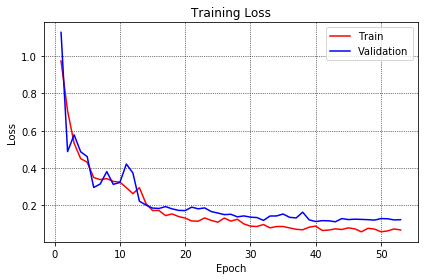

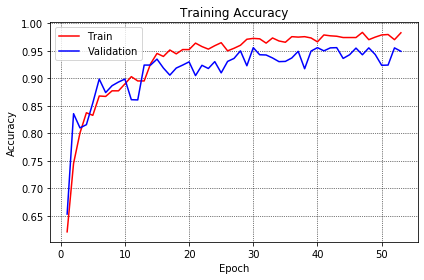

<Figure size 432x288 with 0 Axes>

In [88]:
k = main(folder = folder, csv_path_train = csv_path_train, imgs_folder_train = imgs_folder_train, csv_path_test = csv_path_test,
         imgs_folder_test = imgs_folder_test, lr_init = lr_init ,sched_factor = sched_factor,
         sched_min_lr = sched_min_lr, sched_patience = sched_patience , batch_size = batch_size, epochs = epochs,
         early_stop = early_stop, weights = weights, model_name = model_name, pretrained= pretrained, 
         save_folder = save_folder, best_metric = best_metric,comb_method= comb_method, comb_config= comb_config,
         use_meta_data = use_meta_data)